In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyelsa as elsa
from reconstruction import XrayOperator, feldkamp

pyelsa not build with CUDA projector support


In [13]:
size = np.array([64, 64, 64])
phantom = np.rot90(elsa.phantoms.modifiedSheppLogan(size), -1)

num_angles = 360
arc = 180

s2c = size[0] * 100
c2d = size[0] 
sd = s2c + c2d

projector = feldkamp.Feldkamp(size, [120,120], np.linspace(0, arc, num_angles), s2c, c2d, cor_offset=[0,0,0],pp_offset=[0,0])
sino = projector.apply(phantom)
recon = projector.applyAdjoint(sino)

[2023-12-25 18:50:35.208] [phantom::modifiedSheppLogan] [info] creating modified Shepp Logan phantom of size 64^3
[2023-12-25 18:50:35.208] [phantom::modifiedSheppLogan] [info] rasterize Ellipsoid with amplitude 1, center (32,32,32) , half axis (22,29,26) euler angels (0,0,0)
[2023-12-25 18:50:35.210] [phantom::modifiedSheppLogan] [info] rasterize Ellipsoid with amplitude -0.8, center (32,31,32) , half axis (21,28,25) euler angels (0,0,0)
[2023-12-25 18:50:35.211] [phantom::modifiedSheppLogan] [info] rasterize Ellipsoid with amplitude -0.2, center (39,32,32) , half axis (3,10,7) euler angels (-18,0,10)
[2023-12-25 18:50:35.211] [phantom::modifiedSheppLogan] [info] rasterize Ellipsoid with amplitude -0.2, center (25,32,32) , half axis (5,13,9) euler angels (18,0,10)
[2023-12-25 18:50:35.211] [phantom::modifiedSheppLogan] [info] rasterize Ellipsoid with amplitude 0.1, center (32,43,27) , half axis (7,8,13) euler angels (0,0,0)
[2023-12-25 18:50:35.211] [phantom::modifiedSheppLogan] [info

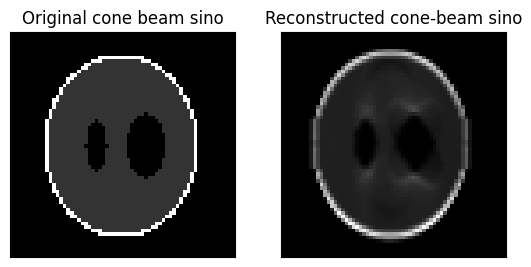

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(phantom[32,:,:].T, cmap="gray")
ax1.set_title("Original cone beam sino")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2.imshow(recon[32,:,:], cmap="gray")
ax2.set_title("Reconstructed cone-beam sino")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)